# Unsupervised Learning
## k-means Demo

Now let's see a demo of unsupervised learning. I took the small amount of data that we had from the dogs and cats example and I generated some more data at random that fit a similar pattern¹. In this notebook we load in that data, and apply the k-means algorithm.

<sub>¹ If you are interested, I fit a multivariate Gaussian to each set of points, tweaked slightly, then used these to generate new points. This actually generated some erroneous points that have negative values! Though you obviously can't see them on the graph. You can remove the points, though this throws off the random number generation/selection of centroids enough that you get different results to those in the unit material, so I left them in. A good lesson in making sure you sanitise your data!</sub>

Let's start by loading in the data.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

all_data = np.load('data.npy')

print(f'The shape of all_data is {all_data.shape}')

The shape of all_data is (2, 100)


Our goal is to label each point with an integer representing the class/cluster to which it belongs. So we create an array with the same length as the number of data points called `labels`.

Notice that each integer itself in the result has no intrinsic meaning. In an example with 2 clusters, you could swap all of the labels, and you'd consider this *the same* clustering result. In an example with 5 clusters there would be 5! = 120 different ways to assign the labels that would all be the exact same clustering.

k-means requires us to specify the number of clusters, `k`. We know this data came from two groups, so we set `k = 2`. But you can change this in the code below to experiment.

Here our labels start as zeros by default, but this won't be used – we will assign new values in the range $0, 1, \dots, k-1$ which will represent each cluster.

In [2]:
labels = np.zeros(all_data.shape[1], dtype=np.int)

k = 2

Now we start the k-means algorithm by choosing k data points at random to be *centroids*, or *means*. We will then alternate between allocating each point to the nearest centroid, then recalculating the centroids based on the allocations.

First of all, let's choose the two random centroids – the code below might look complicated but it is really just ensuring that we don't end up picking the same point twice! Also, I start by setting the random seed – comment out this line to get different random results each time you run.

In [3]:
# set the random seed for deterministic randomness
# comment out this line to get different results each time
np.random.seed(3)

# pick the centroids at random from the data
centroids = np.zeros((2, k))
rand_point_indices = np.random.choice(all_data.shape[1], k, replace=False)
for i in range(k):
    centroids[:, i] = all_data[:, rand_point_indices[i]]
    print(f'centroid {i} is at {centroids[:, i]}')

centroid 0 is at [21.45119362 15.47366237]
centroid 1 is at [20.371226   11.22157053]


Now let's plot the data and our centroids using `matplotlib`. It's many lines of code for what is ultimately something quite simple and purely for presentation! Bear that in mind as you look at examples further down the page.

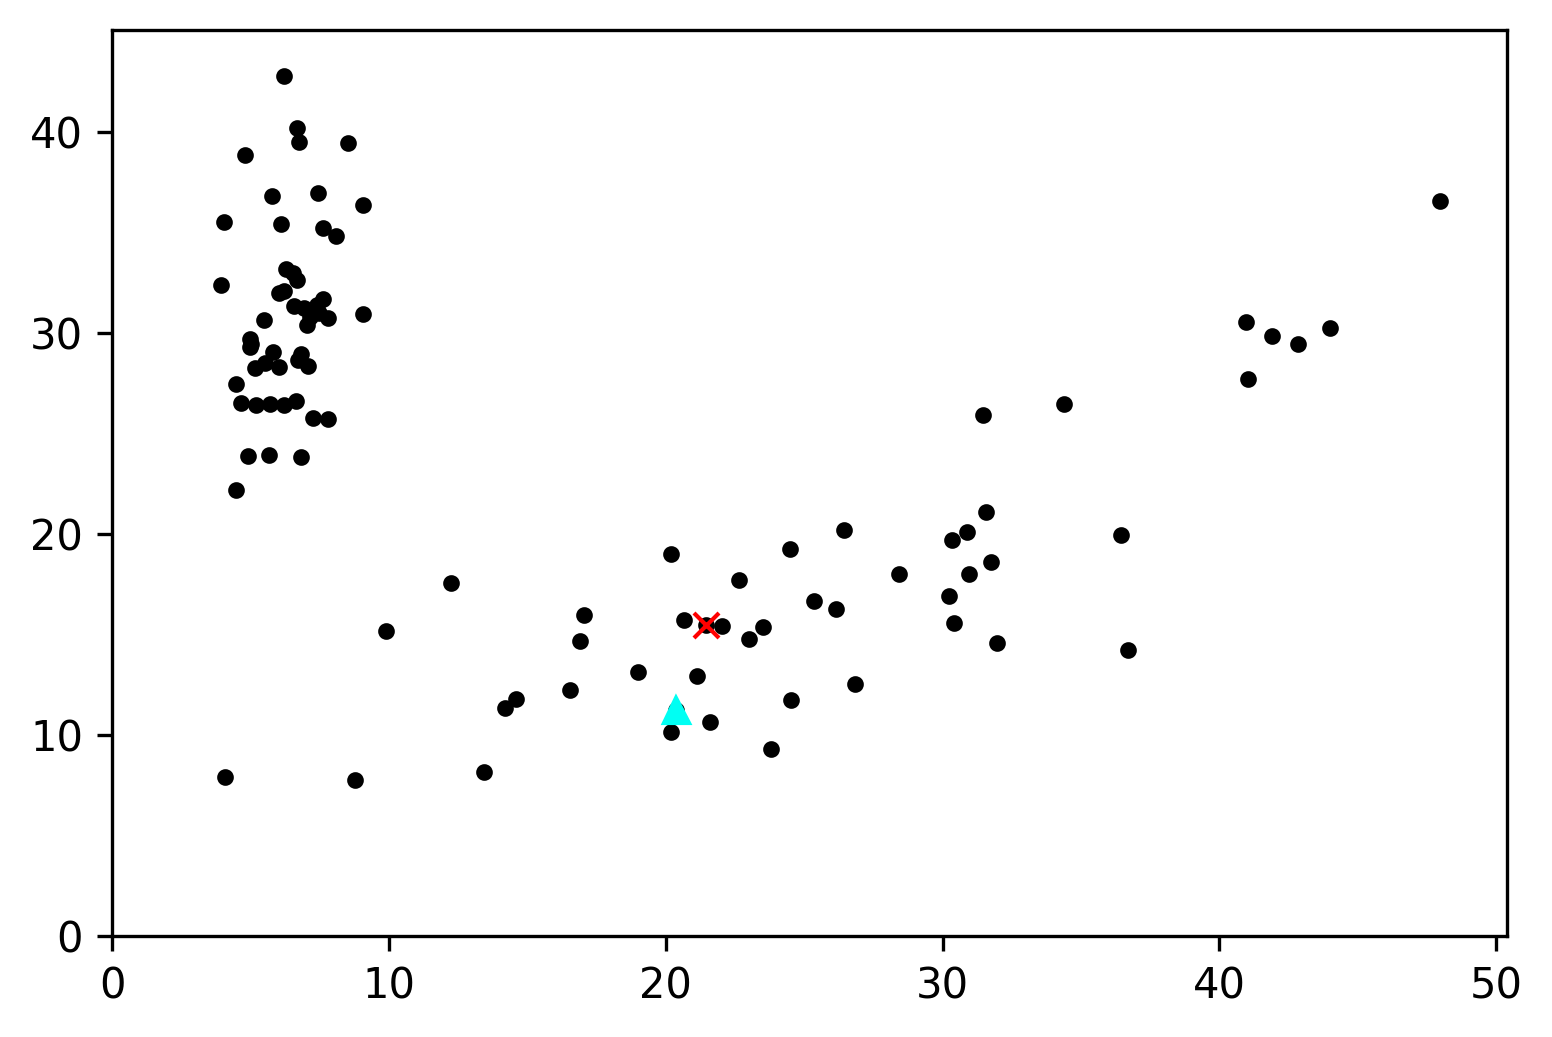

In [4]:
# first, make some random colours and markers (have tried to make this colourblind friendly!)
colours = plt.cm.get_cmap('hsv', k + 1)
dullcolours = []
for i in range(k):
    colour = colours(i)
    dullcolour = (max(colour[0], 0.6), max(colour[1], 0.6), max(colour[2], 0.6), 1)
    dullcolours.append(dullcolour)
    
markers = "x^1spP*D|_>38Hd"


# now plot the original data in black quite small
fig = plt.figure(dpi=150)
plt.plot(all_data[0,:], all_data[1,:], 'ok', ms=3)

# now plot the centroids on top in random colours a bit bigger
for i in range(k):
    plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=colours(i))

a = plt.axis()
plt.axis([0, a[1], 0, a[3]])
plt.show()

Now we start the main body of the algorithm. We go through each point in the dataset and find the closest centroid, this gives us its cluster number (the `centroid_index` in the code below).

Then we plot the data points again showing which cluster they have been assigned to.

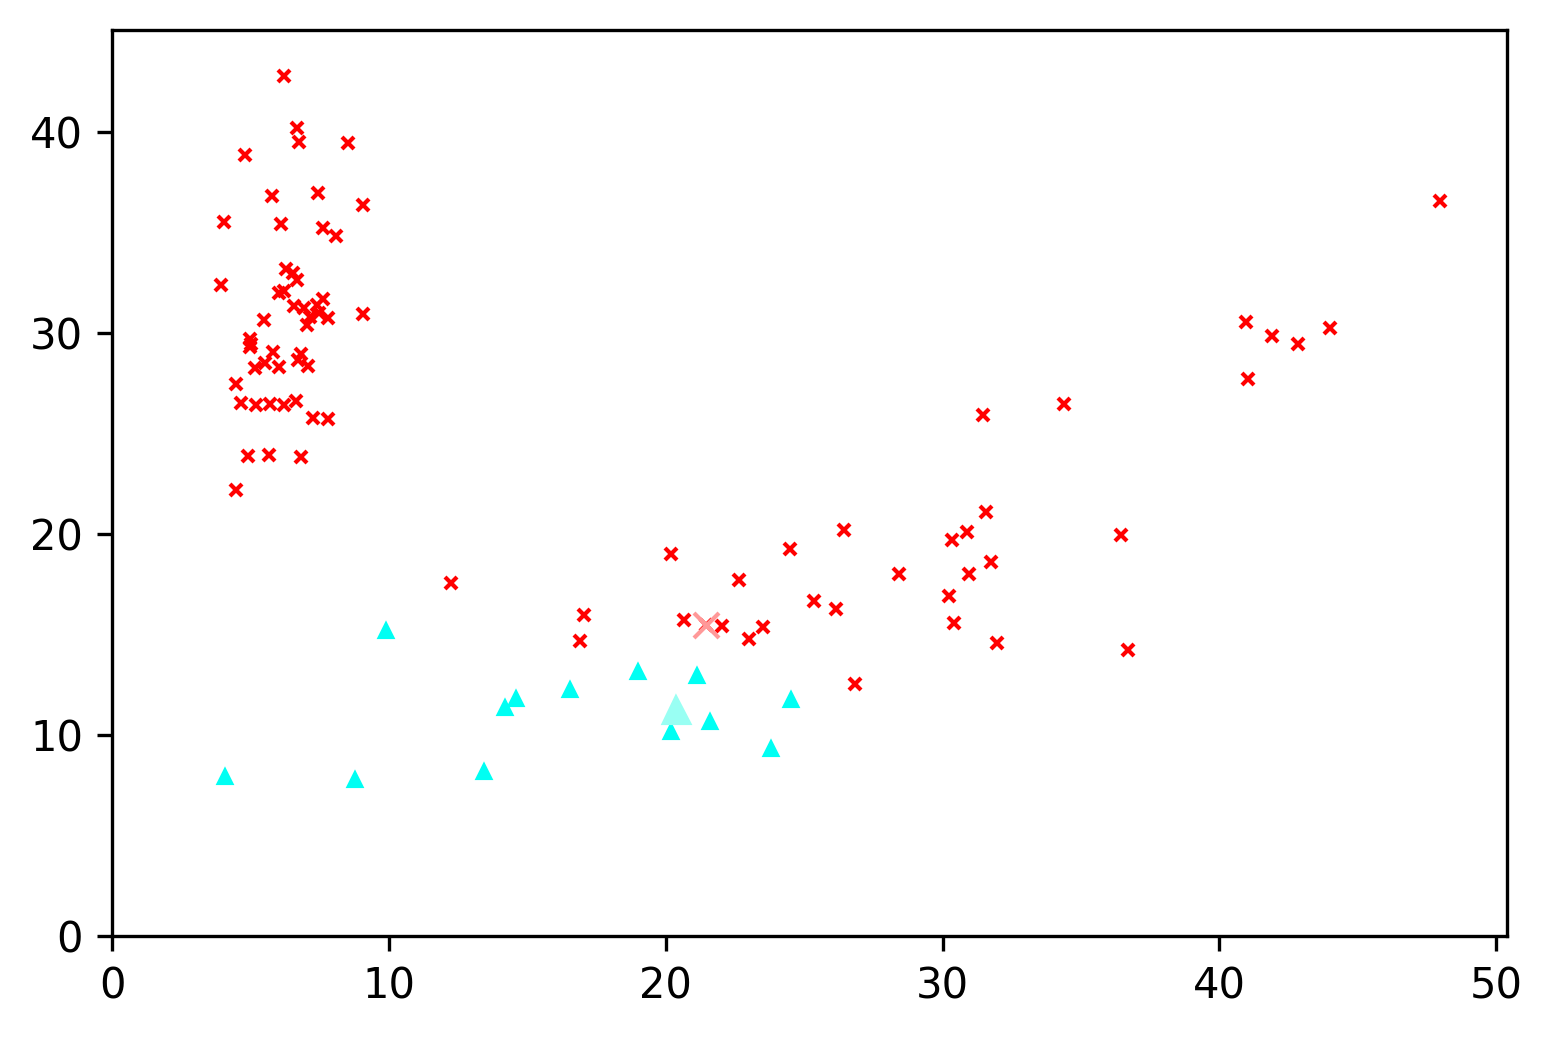

In [5]:
# round one of the k-means algorithm

def k_means_labels(all_data, centroids, labels):
    num_changed = 0
    k = centroids.shape[1]
    
    for data_index in range(all_data.shape[1]):
        # find the distance from this point to each centroid
        this_point = all_data[:, data_index]

        min_dist = float("inf")
        closest_centroid = -1
        for centroid_index in range(k):
            this_centroid = centroids[:, centroid_index]

            # squared distance, no need to square root since we're just looking for smallest
            distance = np.power(this_point[0] - this_centroid[0], 2) + \
                       np.power(this_point[1] - this_centroid[1], 2)

            if distance < min_dist:
                min_dist = distance
                closest_centroid = centroid_index

        if labels[data_index] != closest_centroid:
            labels[data_index] = closest_centroid
            num_changed += 1

    return num_changed
    
    
# run the function above, *note that the labels array is updated by the function*
k_means_labels(all_data, centroids, labels)


# plot the data points again, coloured by label with corresponding marker
fig = plt.figure(dpi=150)
for i in range(k):
    plt.plot(all_data[0, labels==i], all_data[1, labels==i], linestyle="None", marker=markers[i % len(markers)], c=colours(i), ms=3)
    plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=dullcolours[i])

a = plt.axis()
   
# the semi-colon here prevents Jupyter from printing the output – not a C-like typo!
plt.axis([0, a[1], 0, a[3]]);

Now we go through each cluster, take all of the points that have been assigned to the cluster, and calculate the mean point (the mean value in each dimension – in this case the data is 2D). This becomes the new centroid for the cluster.

Numpy makes these kinds of operations easy to write with logical indexing, but it might not be the easiest thing to read!

* `labels == i` produces an array of True and False values <br>
* `all_data[:, labels == i]` says to only take the columns from `all_data` where those values are True, i.e. where the label is equal to `i` <br>
* `np.mean(all_data[:, labels == i], axis=1)` says to take the mean (average) across the columns (`axis=1`), giving us a single column vector which is the mean point – the new centroid

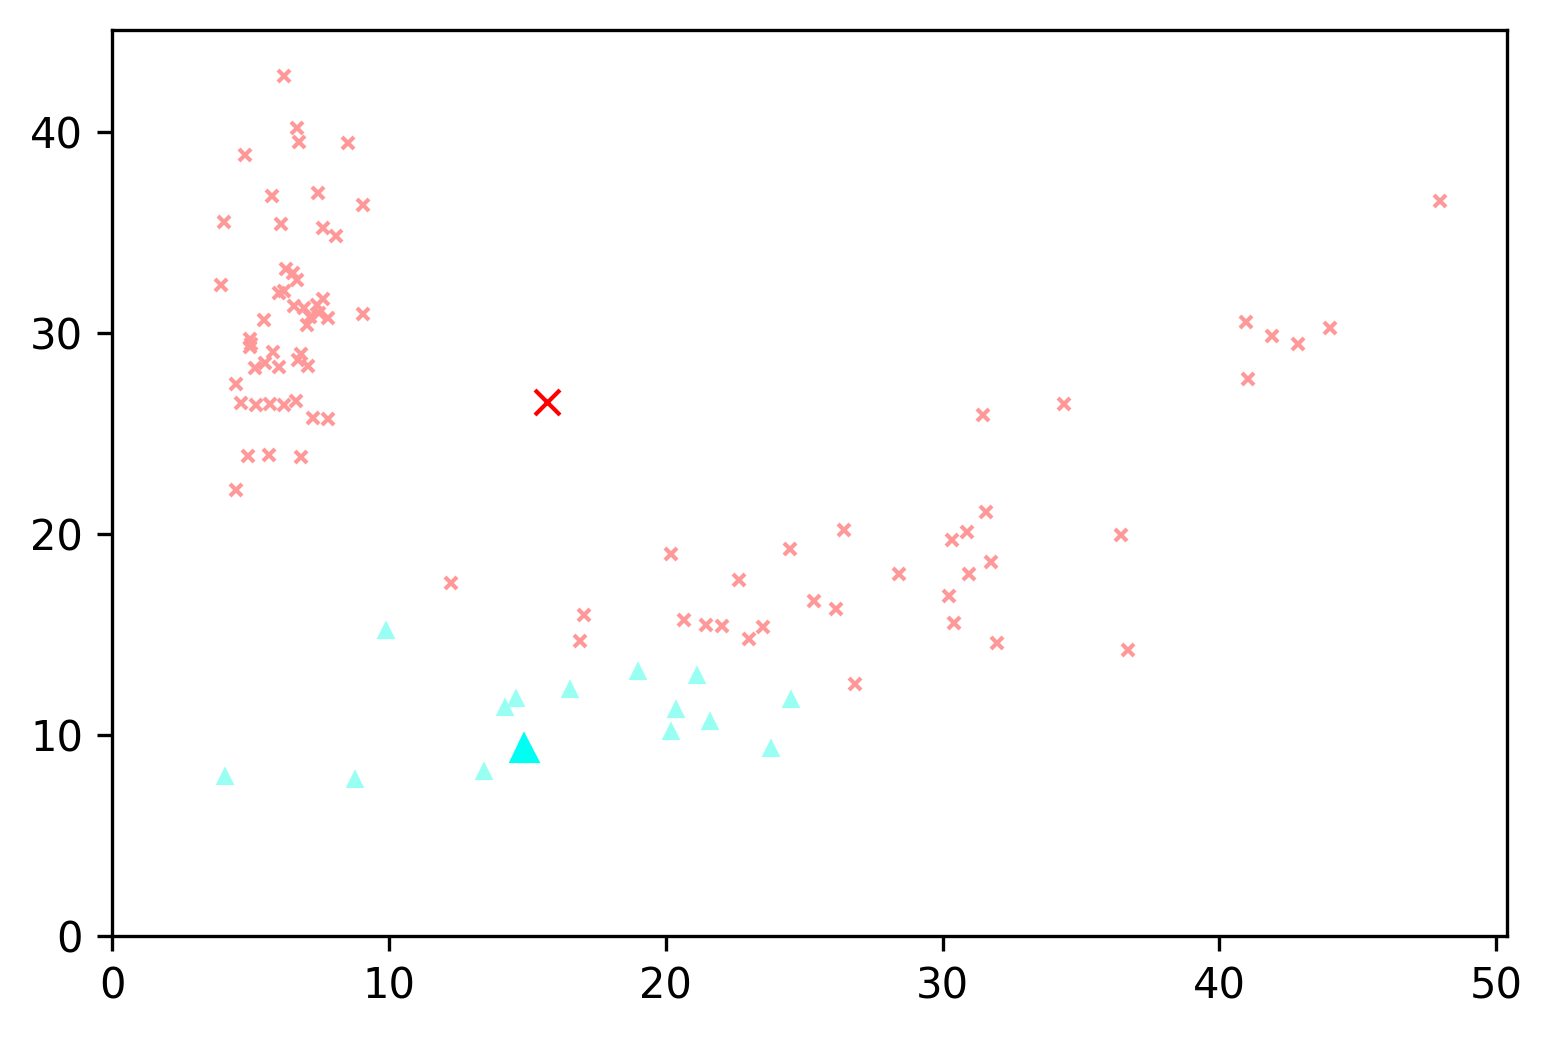

In [6]:
# now update the centroids
def k_means_centroids(all_data, centroids, labels):
    for i in range(centroids.shape[1]):
        centroids[:, i] = np.mean(all_data[:, labels == i], axis=1)
    
k_means_centroids(all_data, centroids, labels)

# plot the new centroids, coloured by label with corresponding marker
fig = plt.figure(dpi=150)
for i in range(k):
    plt.plot(all_data[0, labels==i], all_data[1, labels==i], linestyle="None", marker=markers[i % len(markers)], c=dullcolours[i], ms=3)
    plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=colours(i))

a = plt.axis()
plt.axis([0, a[1], 0, a[3]]);

Notice the centroids have moved away from the original data points, in fact they are no longer tied to any point in the dataset – one is in in an area with no other points nearby.

We need to keep alternating between these two actions: assign points, calculate means, assign points again. We keep doing this until the assignment is stable: we go a full round without changing any label. We expect to see many points change in early rounds, sometimes in the final rounds only 1 or 2 points will change.

Reassign labels:


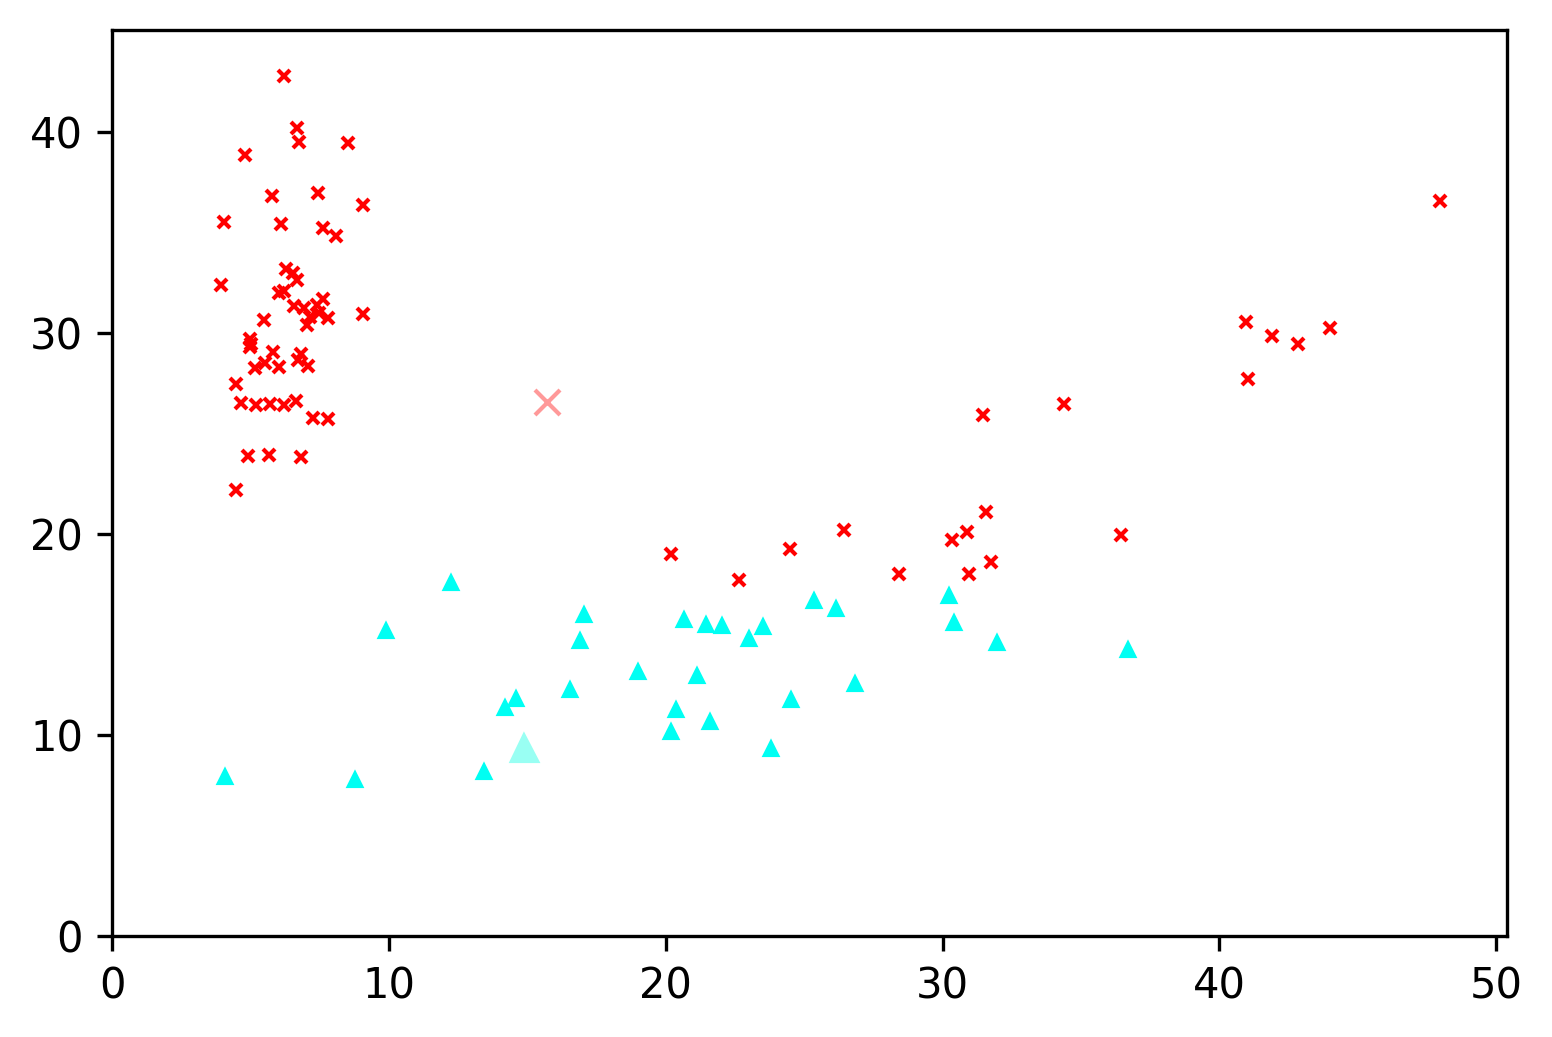

Recalculate means:


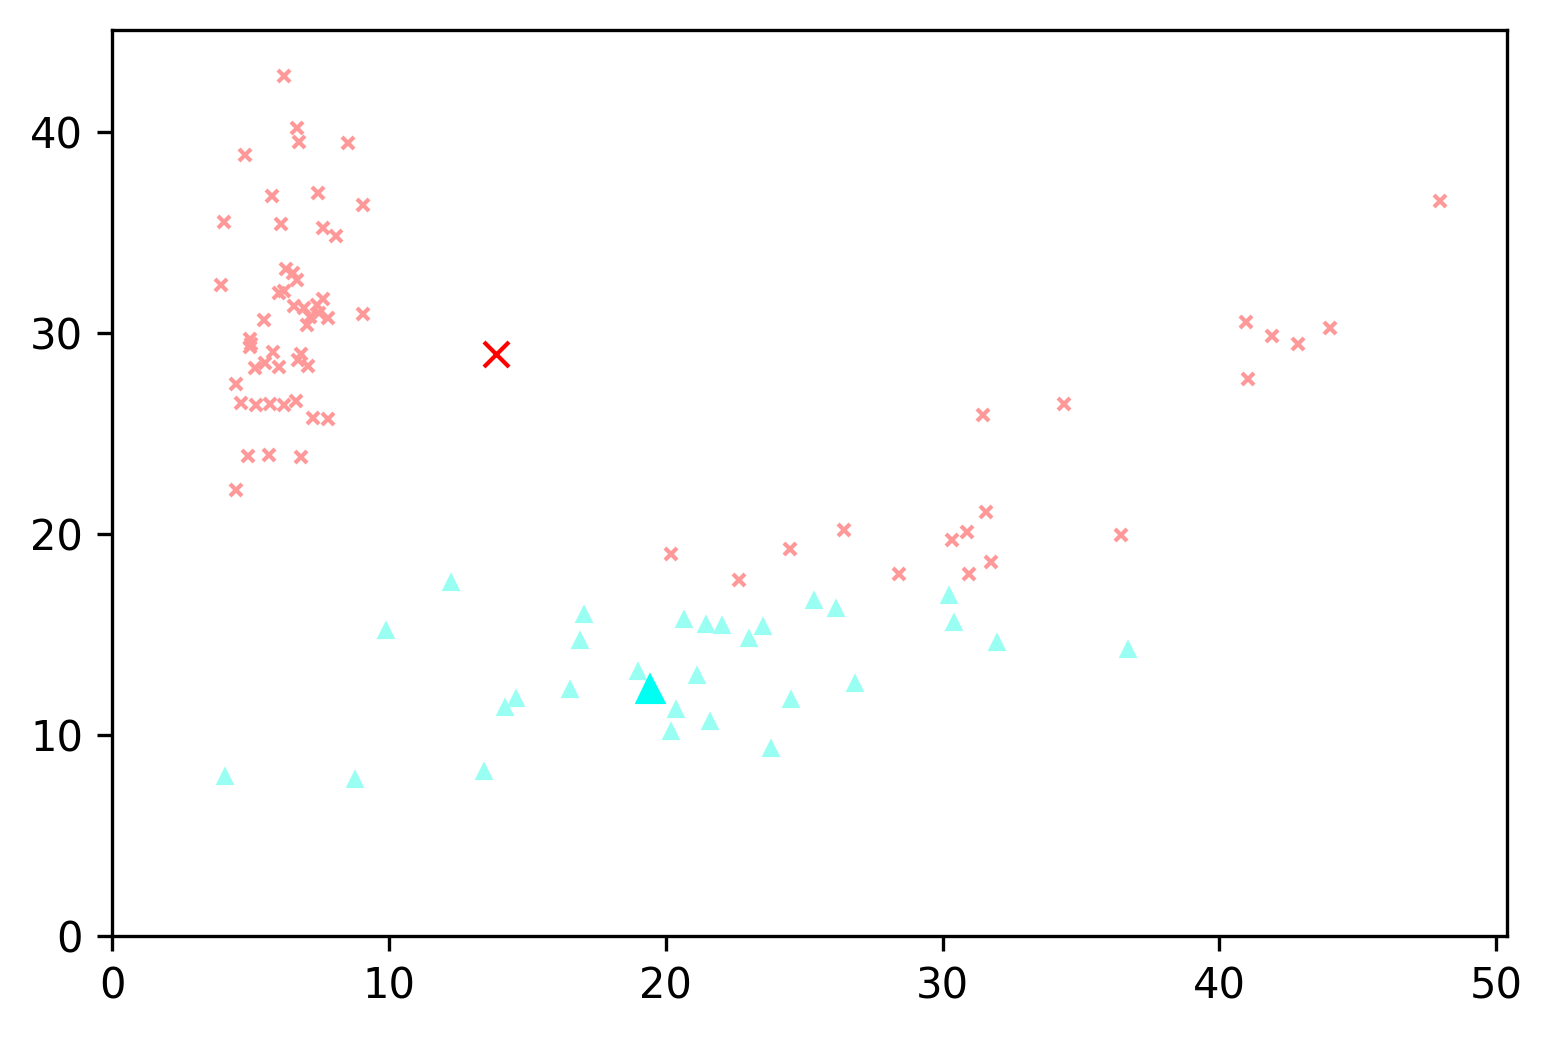

Reassign labels:


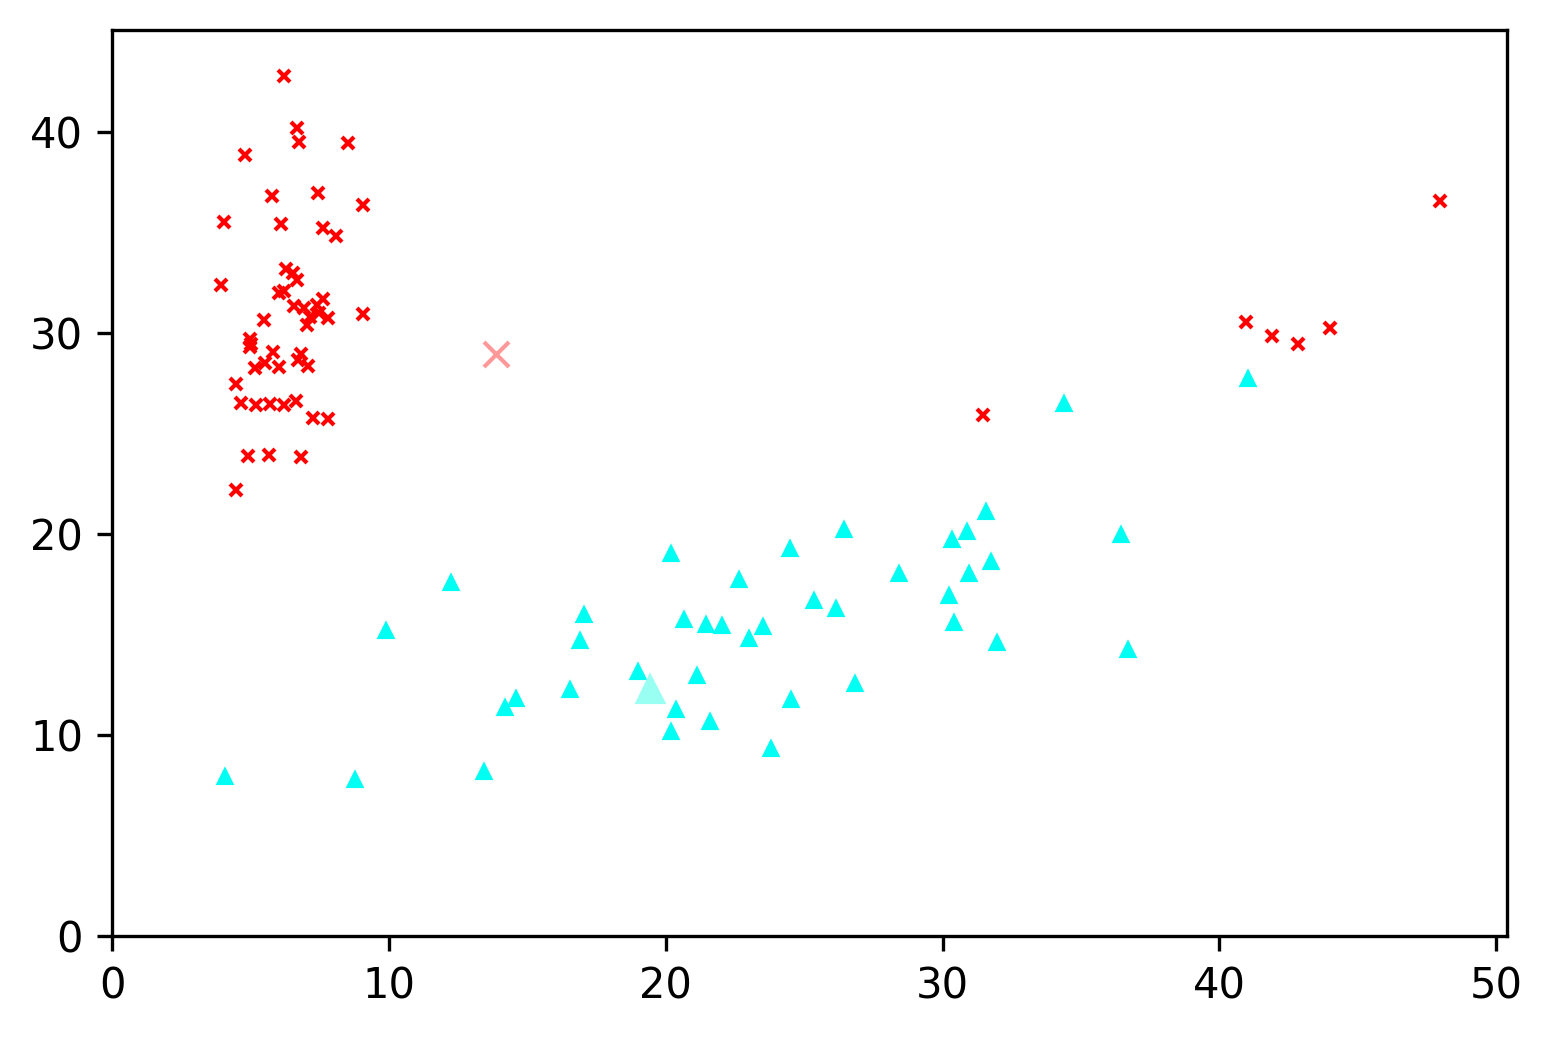

Recalculate means:


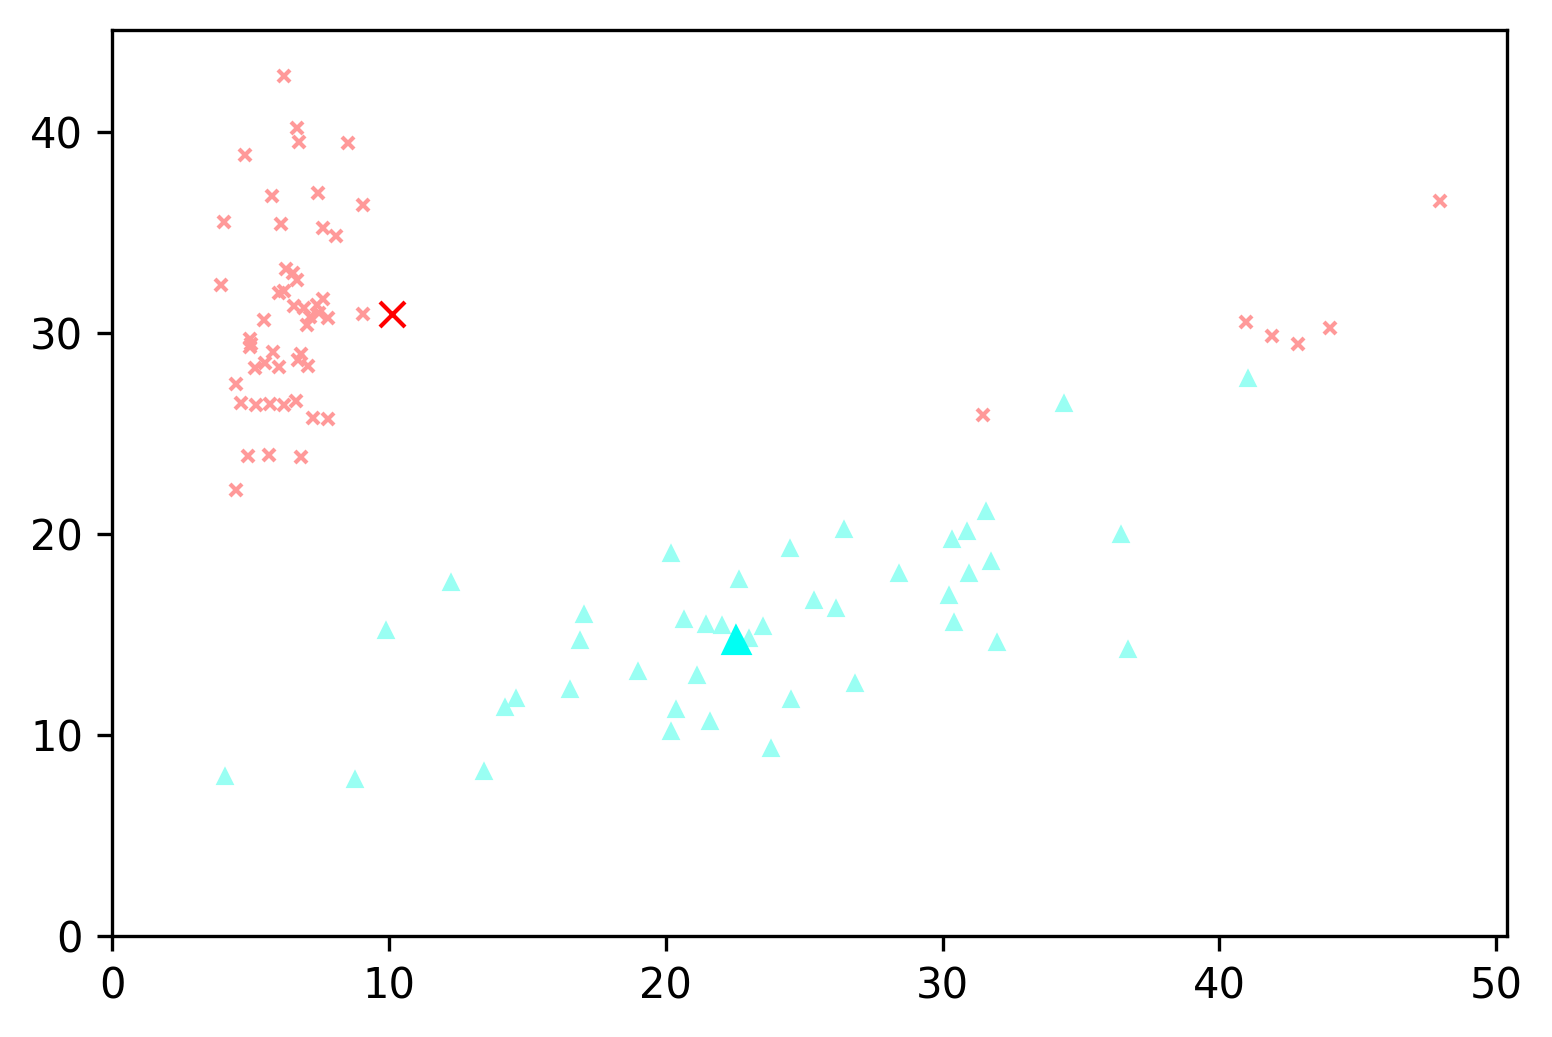

Reassign labels:


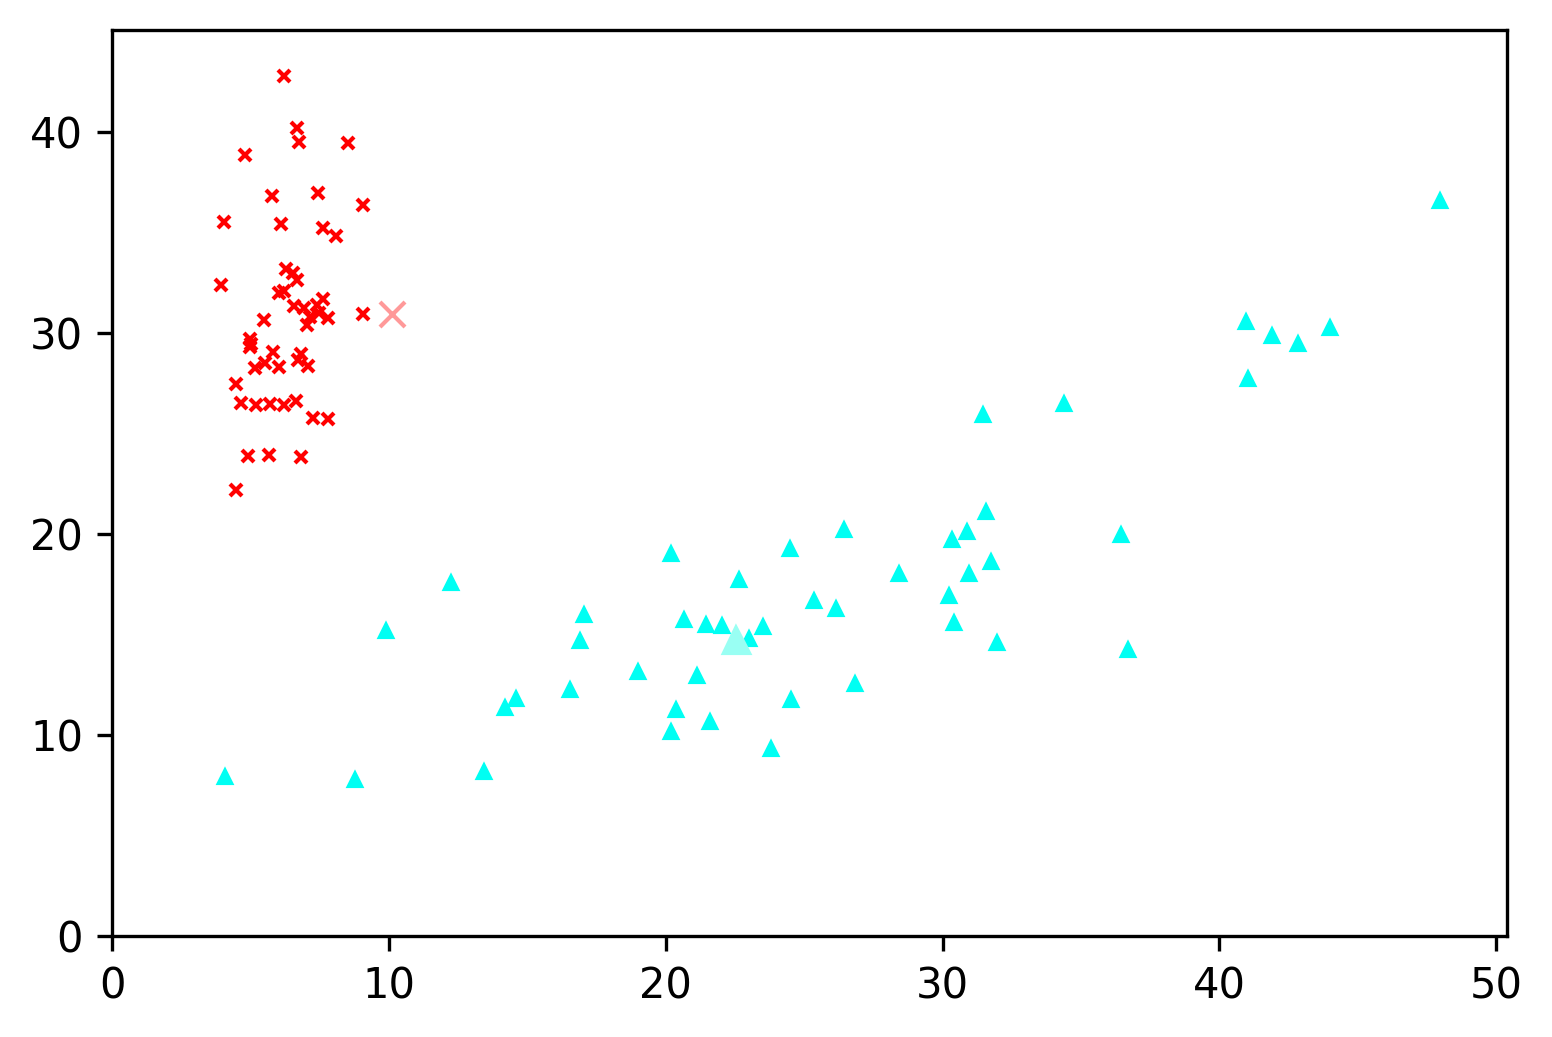

Recalculate means:


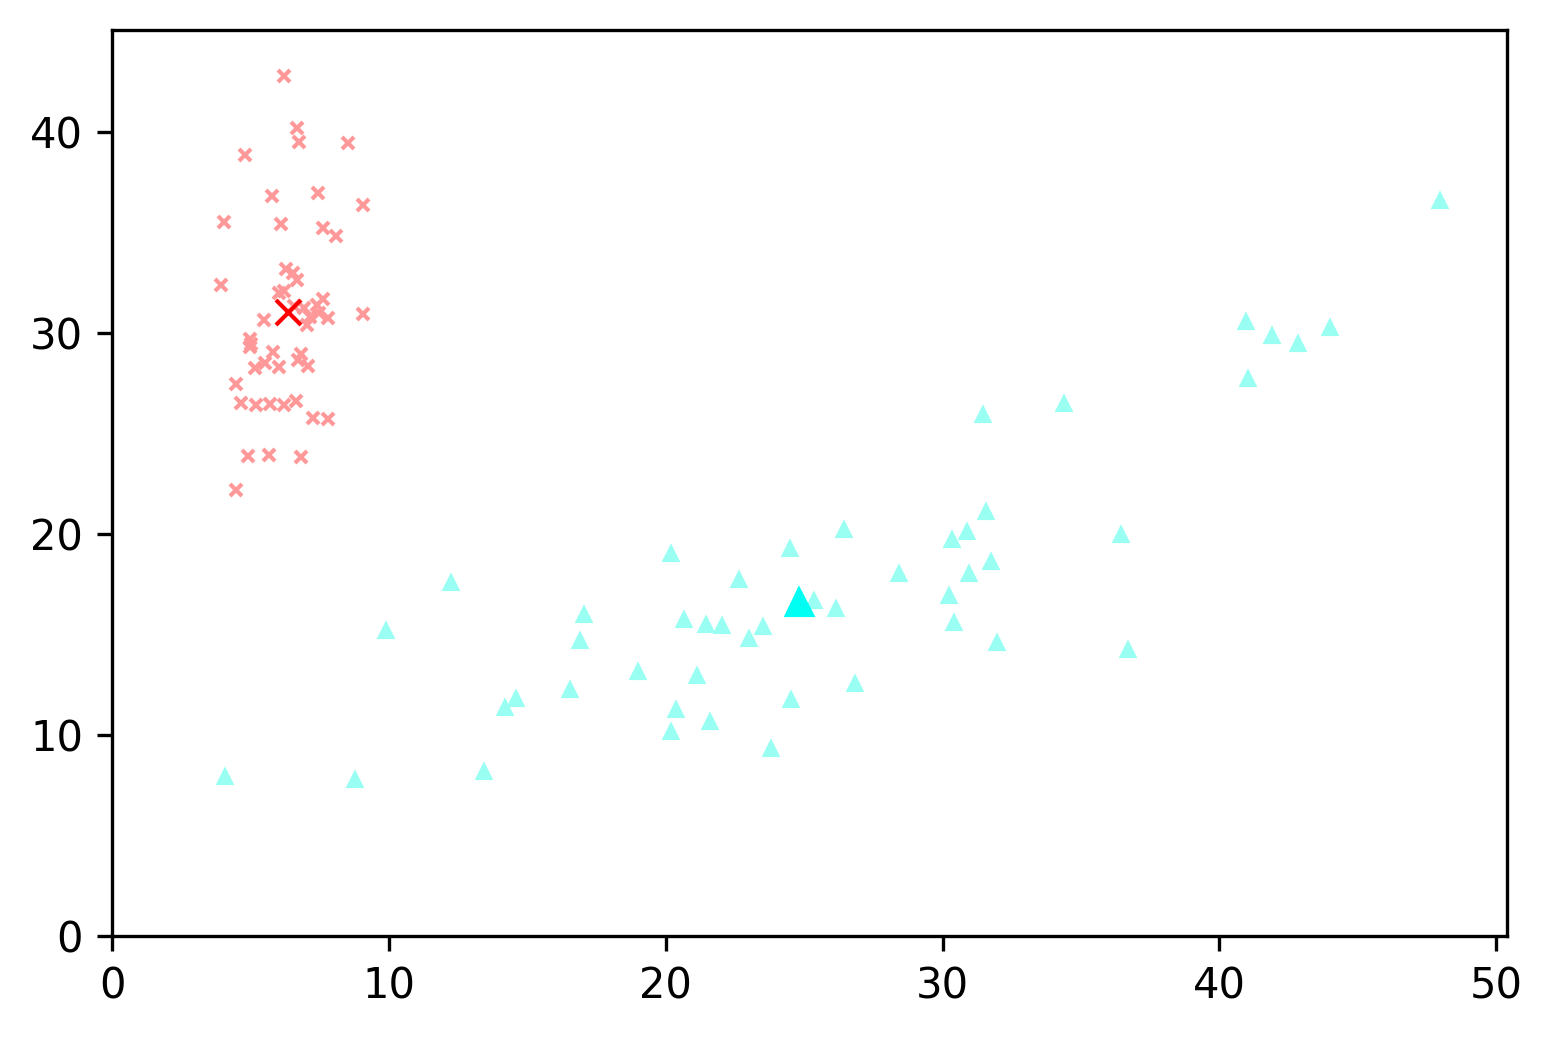

Reassign labels:


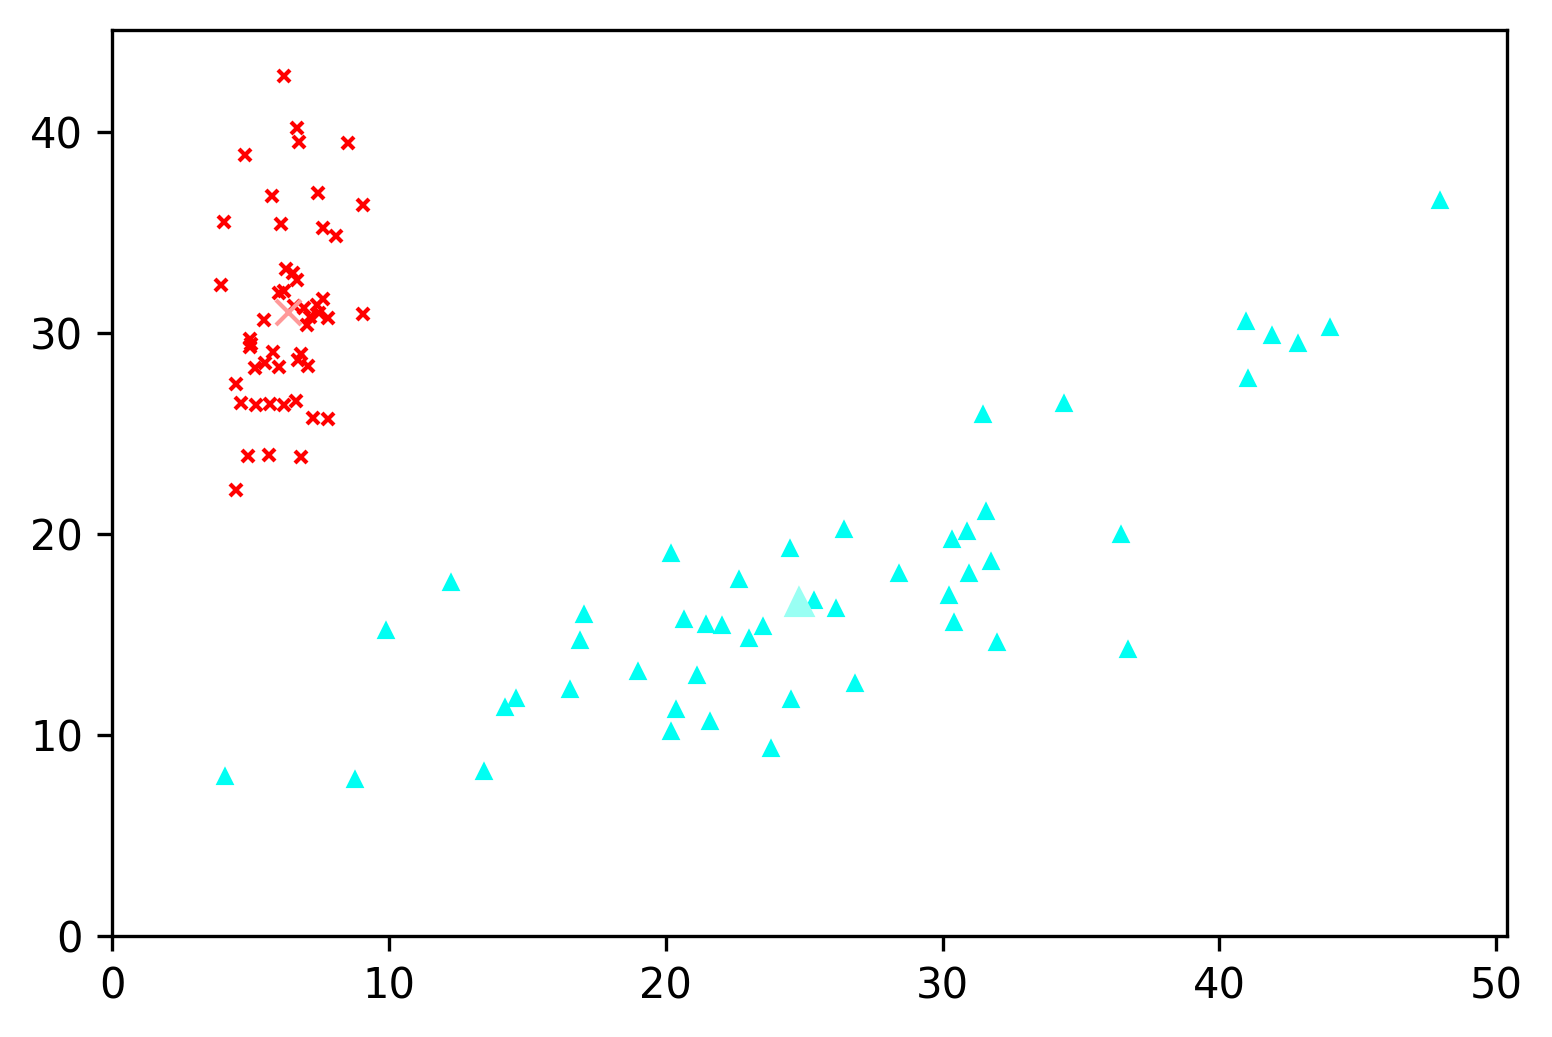

No points changed!
Total 4 iterations


In [7]:
# now loop between updating points and then centroids until convergence
def k_means_loop(all_data, centroids, labels, plot=True):
    iterations = 0
    while True:
        iterations += 1
        num_changed = k_means_labels(all_data, centroids, labels)
        
        if plot:
            print("Reassign labels:")
            fig = plt.figure(dpi=150)
            for i in range(k):
                plt.plot(all_data[0, labels==i], all_data[1, labels==i], linestyle="None", marker=markers[i % len(markers)], c=colours(i), ms=3)
                plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=dullcolours[i])

                a = plt.axis()

            plt.axis([0, a[1], 0, a[3]])
            plt.show()
        
        
        if num_changed == 0:
            if plot: print("No points changed!")
            break
            
            
        k_means_centroids(all_data, centroids, labels)
        
        if plot:
            print("Recalculate means:")
            fig = plt.figure(dpi=150)
            for i in range(k):
                plt.plot(all_data[0, labels==i], all_data[1, labels==i], linestyle="None", marker=markers[i % len(markers)], c=dullcolours[i], ms=3)
                plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=colours(i))

                a = plt.axis()

            plt.axis([0, a[1], 0, a[3]])
            plt.show()


    return iterations


iterations = k_means_loop(all_data, centroids, labels)
print(f"Total {iterations} iterations")

### Exercises
#### Part One
Try modifying the code to change the value of `k` to see how it performs when you select the wrong number of clusters. Have a think about what kind of tests you might be able to run on the clustered data to determine whether the value of k is correct.

#### Part Two
In the cell below I run the entire algorithm again from scratch. I set the random seed back to being nondeterministic, so you may get different results each time you run it. You can also uncomment a line of code to delete the erroneous points I mentioned in the footnote at the top of the page to see how that changes the result (the hidden negative points do affect it).

First of all, run the code a few times to see how results differ.

Then try finding a new dataset online, and using the code below to cluster it. One famous dataset is the Old Faithful eruption data, hosted in many places online but easily accessible here: https://gist.github.com/curran/4b59d1046d9e66f2787780ad51a1cd87

But you can use any dataset that you are interested in. You should try to interpret the results also: the Old Faithful dataset seems to have two distinct clusters, what does this actually tell us about the ways geysers erupt?

You can use numpy to read in csv or tsv files, for an example look back at the original dogs and cats example in the supervised learning section.

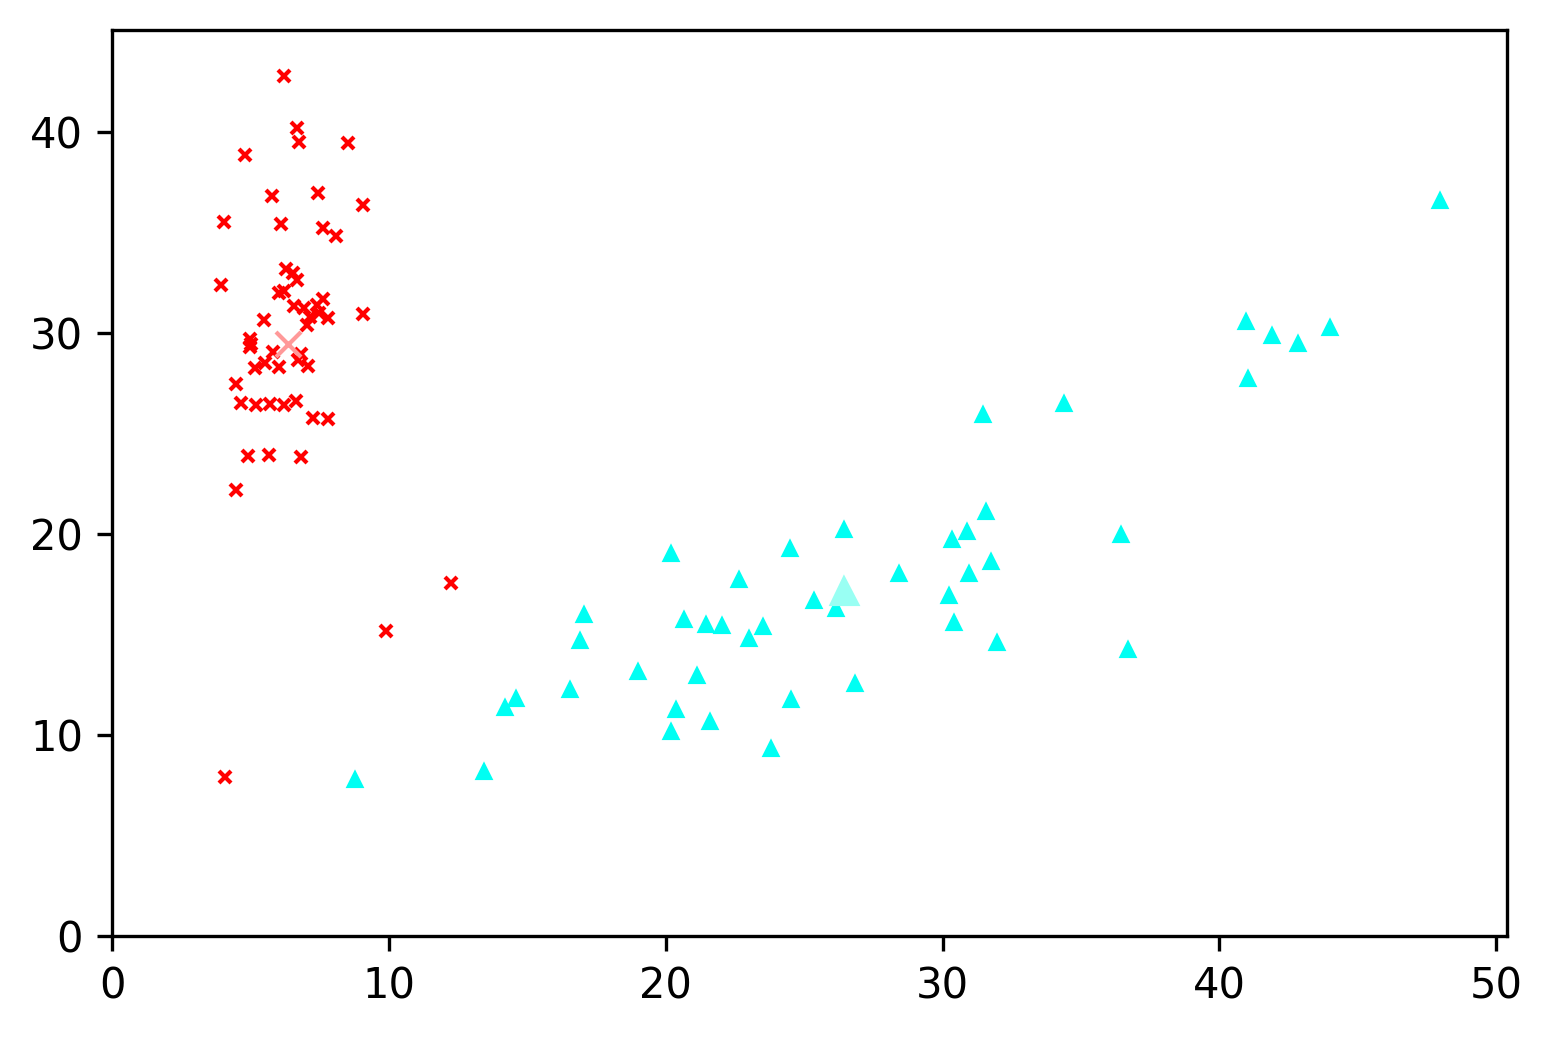

In [24]:
def k_means(all_data, k, verbose=False):
    labels = np.zeros(all_data.shape[1], dtype=np.int)
    
    centroids = np.zeros((2, k))
    rand_point_indices = np.random.choice(all_data.shape[1], k, replace=False)
    for i in range(k):
        centroids[:, i] = all_data[:, rand_point_indices[i]]
        if verbose: print(f'centroid {i} is at {centroids[:, i]}')

    iterations = k_means_loop(all_data, centroids, labels, plot=verbose)
    if verbose: print(f"Total {iterations} iterations")
        
    return labels, centroids

all_data = np.load('data.npy')

# delete erroneous negative values
# all_data = np.delete(all_data, np.where(all_data < 0)[1], axis = 1)

# reset random seed
np.random.seed(None)

# perform k-means
labels, centroids = k_means(all_data, k=2)

# plot results
fig = plt.figure(dpi=150)
for i in range(k):
    plt.plot(all_data[0, labels==i], all_data[1, labels==i], linestyle="None", marker=markers[i % len(markers)], c=colours(i), ms=3)
    plt.plot(centroids[0, i], centroids[1, i], marker=markers[i % len(markers)], c=dullcolours[i])

    a = plt.axis()

plt.axis([0, a[1], 0, a[3]])
plt.show()
